In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as web
import math
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
import time

### Load the data

In [2]:
full_df = pd.read_csv('AMZN.csv')

In [3]:
df = full_df[2607:2841]
df = df.reset_index(drop=True)

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-13,2366.800049,2407.699951,2337.800049,2367.919922,2367.919922,4782900
1,2020-05-14,2361.010010,2391.370117,2353.209961,2388.850098,2388.850098,3648100
2,2020-05-15,2368.520020,2411.000000,2356.370117,2409.780029,2409.780029,4235000
3,2020-05-18,2404.350098,2433.000000,2384.010010,2426.260010,2426.260010,4366600
4,2020-05-19,2429.830078,2485.000000,2428.969971,2449.330078,2449.330078,4320500


In [5]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
229,2021-04-12,3355.209961,3395.040039,3351.149902,3379.389893,3379.389893,3281800
230,2021-04-13,3400.850098,3432.000000,3395.629883,3400.000000,3400.000000,3315800
231,2021-04-14,3404.040039,3404.129883,3326.000000,3333.000000,3333.000000,3145200
232,2021-04-15,3371.000000,3397.000000,3352.000000,3379.090088,3379.090088,3233600
233,2021-04-16,3380.000000,3406.800049,3355.590088,3399.439941,3399.439941,3183300


In [6]:
df.describe(include='all', datetime_is_numeric=True)

,Date,Open,High,Low,Close,Adj Close,Volume
count,234,234.000000,234.000000,234.000000,234.000000,234.000000,2.340000e+02
unique,234,NaN,NaN,NaN,NaN,NaN,NaN
top,2020-12-24,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3090.223421,3127.376999,3047.727092,3087.564821,3087.564821,4.295885e+06
std,NaN,257.696553,258.275722,252.063767,253.622736,253.622736,1.425855e+06
min,NaN,2361.010010,2391.370117,2330.000000,2367.919922,2367.919922,1.451900e+06
25%,NaN,3056.217468,3091.437500,2997.327515,3049.277405,3049.277405,3.185025e+06
50%,NaN,3152.334961,3187.314941,3111.619995,3147.079956,3147.079956,4.022500e+06
75%,NaN,3233.472534,3282.964966,3184.455017,3235.205078,3235.205078,5.092225e+06


In [7]:
df.shape

(234, 7)

# Average Directional Index 

In [8]:
import numpy as np
import pandas as pd

class AverageDirectionalIndex:

    def __init__(self, high, low, close):

        # Data from a file
        self.test_high = high
        self.test_low = low
        self.test_close = close

        # Calculations data
        self.true_range = []
        self.plus_directional_mov = []
        self.nega_directional_mov = []
        self.true_range_smoothed = []
        self.plus_directional_mov_smoothed = []
        self.nega_directional_mov_smoothed = []
        self.pos_directional_index = []
        self.neg_directional_index = []
        self.directional_movement_index = []
        self.avg_direction_index = []


    # Accepted
    # Calculates true range index
    def true_range_calculate(self, high, low, yestarday_close):
        hl_diff = high - low
        h_yc = abs(high - yestarday_close)
        l_yc = abs(low - yestarday_close)

        # Picks the biggest out of three
        if h_yc <= hl_diff >= l_yc:
            true_range = hl_diff
        elif hl_diff <= h_yc >= l_yc:
            true_range = h_yc
        elif hl_diff <= l_yc >= h_yc:
            true_range = l_yc

        # Returns the biggest
        return true_range


    # Finds directional movement if it's positive or negative
    # Good example
    def directional_movement(self, tod_high, tod_low, yest_high, yest_low):
        moveUp = tod_high - yest_high
        moveDown = yest_low - tod_low

        if 0 < moveUp > moveDown:
            positive_directional_mov = moveUp
        else:
            positive_directional_mov = 0


        if 0 < moveDown > moveUp:
            negative_directional_mov = moveDown
        else:
            negative_directional_mov = 0

        return negative_directional_mov, positive_directional_mov


    def calculate_true_range(self):
        ind = 1
        while ind < len(self.test_high):
            # calculating true range
            # true_range_calculate(high, low, yestarday_close):
            self.true_range.append(self.true_range_calculate(self.test_high[ind], self.test_low[ind], self.test_close[ind - 1]))

            # calculating derectional moving, positive and negative
            # directional_movement(tod_high, tod_low, yest_high, yest_low)
            ng_dir_mov, pl_dir_mov = self.directional_movement(self.test_high[ind], self.test_low[ind], 
                                     self.test_high[ind - 1], self.test_low[ind - 1])
            self.plus_directional_mov.append(pl_dir_mov)
            self.nega_directional_mov.append(ng_dir_mov)

            ind += 1; 



    # Wilder's Smoothing Technique
    # Smooth each period's +DM1, -DM1, and TR1 values over 14 periods
    # First value simply sum of the firs 14 periods
    def moving_wilder_smoothing(self, moving_values):
        smoothed_moving_values = []
        smoothed_moving_values.append(sum(moving_values[:14]))

        ind = 14;
        while(ind < len(moving_values)):
            previous_smoothed_mov_value = smoothed_moving_values[ind - 14]
            current_moving_value = moving_values[ind]

            #print(previous_smoothed_true_range, current_true_range)

            current_smoothed_mov_value = previous_smoothed_mov_value - (previous_smoothed_mov_value / 14) + current_moving_value
            smoothed_moving_values.append(current_smoothed_mov_value)
            ind += 1 
        return smoothed_moving_values


    # Calculates +DI and -DI requered for plotting
    def find_directional_index(self, smoothed_true_range, pos_directional_mov, neg_directional_mov):
        pos_dir_ind = []
        neg_dir_ind = []
        directional_index = []

        for ind in range(0, len(smoothed_true_range)):
            pos_dir_ind.append((pos_directional_mov[ind] / smoothed_true_range[ind] ) * 100)
            neg_dir_ind.append(( neg_directional_mov[ind] / smoothed_true_range[ind] ) * 100)
            diff_ind = abs(pos_dir_ind[ind] - neg_dir_ind[ind])
            sum_ind = pos_dir_ind[ind] + neg_dir_ind[ind];
            directional_index.append(( diff_ind / sum_ind ) * 100)

        return pos_dir_ind, neg_dir_ind, directional_index


    # Average directional index calculation
    def average_directional_index(self, directional_movement_index):
        avg_direct_index = []
        avg_direct_index.append(np.mean(directional_movement_index[:14]))

        for ind in range(14, len(directional_movement_index)):
            avg_direct_index.append((avg_direct_index[ind - 14] * 13 + directional_movement_index[ind]) / 14)
        return avg_direct_index



    def run_average_direction(self):

        # Calculating true range and directional movement
        self.calculate_true_range()

        # Calculating true range smooved values
        true_range_smoothed = self.moving_wilder_smoothing(self.true_range)

        # Calculating +DM1 smoothed values
        plus_directional_mov_smoothed = self.moving_wilder_smoothing(self.plus_directional_mov)

        # Calculating -DM1 smoothed values
        nega_directional_mov_smoothed = self.moving_wilder_smoothing(self.nega_directional_mov)

        # Calculates +DI and -DI
        pos_directional_index, neg_directional_index, directional_movement_index = self.find_directional_index(true_range_smoothed, plus_directional_mov_smoothed, nega_directional_mov_smoothed)

        # Calculating average directional index
        avg_direction_index = self.average_directional_index(directional_movement_index)

        return pos_directional_index, neg_directional_index, avg_direction_index


In [9]:
adx_index = AverageDirectionalIndex(df.High, df.Low, df.Close)

In [10]:
pos_directional_index, neg_directional_index, avg_direction_index = adx_index.run_average_direction()

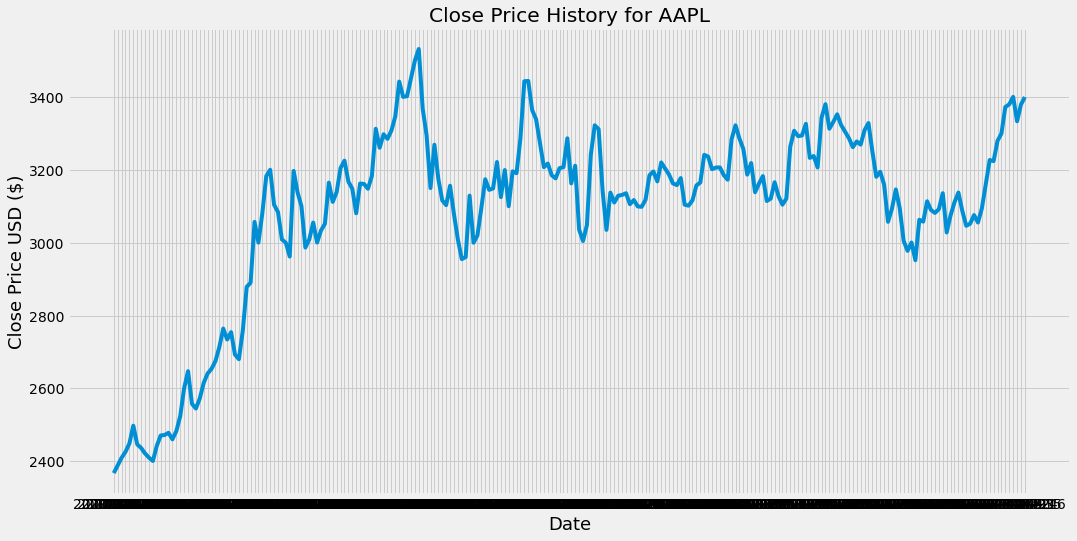

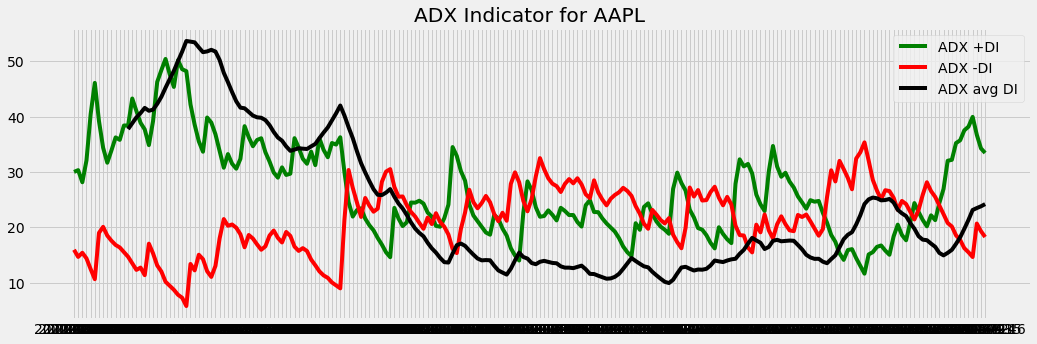

In [11]:
plt.figure(figsize=(16,8))
plt.title('Close Price History for AAPL')
plt.plot(df['Date'], df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

plt.figure(figsize=(16,5))
plt.title('ADX Indicator for AAPL')
plt.plot(df['Date'][14:], pos_directional_index, color='green', label='ADX +DI')
plt.plot(df['Date'][14:], neg_directional_index, color='red', label='ADX -DI')
plt.plot(df['Date'][27:], avg_direction_index, color='black', label='ADX avg DI')
plt.legend()
plt.show()

# Agent

In [12]:
# Determine when to excecute the strategies
class SMA_Agent:
    
    def __init__(self, wallet, data):
        self.data = data
        self.wallet = wallet # Amount of cash in hand
        self.portfolio = 0 # Company stock count
        self.current_market = None
        self.history = [[[],[]],[[],[]]] # 1st arr: Buy history; 2nd arr: sell history. [date, price]
        self.sma_diff = [] #
    
    # Check if the agent can buy the stock
    # Returns: Boolean. True if can buy, False if not
    def can_buy(self, unit):
        if unit == -1:
            if self.wallet >= self.current_market['Open']:
                return True
        else:
            if self.wallet >= unit*self.current_market['Open']:
                return True
        return False
    
    # Check if the agent can sell the stock
    # Returns: Boolean. True if can sell, False if not
    def can_sell(self, unit):
        if unit == -1:
            if self.portfolio > 0:
                return True
        else:
            if self.portfolio >= unit:
                return True
        return False
    
    # Buys x unit of stock. -1 to spend all
    def buy(self, unit):
        current_price = self.current_market['Open'] # price 1 stock
        # Update fields
        if unit == -1:
            unit = math.floor(self.wallet/current_price)
        self.wallet -= unit*current_price
        self.portfolio += unit
        self.history[0][0].append(self.current_market['Date'])
        self.history[0][1].append(current_price)
    
    # Sells x unit of stock. -1 to sell all
    def sell(self, unit):
        current_price = self.current_market['Open'] # price 1 stock
        # Update fields
        if unit == -1:
            unit = self.portfolio
        self.wallet += unit*current_price
        self.portfolio -= unit
        self.history[1][0].append(self.current_market['Date'])
        self.history[1][1].append(current_price)
    
    # Computes the total balance: wallet + holdings
    def total_balance(self):
        current_price = self.current_market['Open'] # price 1 stock
        return self.wallet + current_price*self.portfolio
    
    # Computes the "smooth moving average of past 50 days"
    def sma50(self):
        date = self.current_market.Date
        index = self.data.loc[self.data['Date'] == date].index[0]
        return self.data['Open'].rolling(window=50, center=False).mean()[index]
    
    # Computes the "smooth moving average of past 20 days"
    def sma20(self):
        date = self.current_market.Date
        index = self.data.loc[self.data['Date'] == date].index[0]
        return self.data['Open'].rolling(window=20, center=False).mean()[index]
    
    # Defines the buying/selling strategy
    # Buy when sma20 goes above sma50
    # Sell when sma20 goes below sma50
    def strategy(self):
        #print('In strategy')
        pdi = np.array(pos_directional_index)
        ndi = np.array(neg_directional_index)
        adi = np.array(avg_direction_index)

        index = 13
        for i in range(len(adi)):
            self.current_market = self.data.iloc[index]
            cur_adi = adi[i]
            cur_pdi = pdi[index]
            cur_ndi = ndi[index]
            
            if cur_adi >= 25:
                if SMA_Agent.can_buy(self,-1):
                    if cur_pdi >= cur_ndi and SMA_Agent.can_buy(self,-1):
                        SMA_Agent.buy(self,-1)

                if cur_ndi > cur_pdi and SMA_Agent.can_sell(self,-1):
                    SMA_Agent.sell(self,-1)
                
            index+=1
                
    
    # Given a dataframe computes the buy and sell signals
    def deploy(self):
        #print('In Deploy')
        SMA_Agent.strategy(self)
        return self.history

    
# Inputs
invest = 3000

agent = SMA_Agent(invest, df)
buy_info, sell_info = agent.deploy()

In [13]:
# Check performance
print('Invested:', invest)
print('End of day total balance:', agent.total_balance())
print('Percentage gain:', 100*(agent.total_balance()-invest)/invest, '%')
print('Baseline:', 100*(df.iloc[-1].Open-df.iloc[0].Open)/df.iloc[0].Open, '%')
print()

Invested: 3000
End of day total balance: 3749.1201170000004
Percentage gain: 24.970670566666676 %
Baseline: 42.80885288252755 %



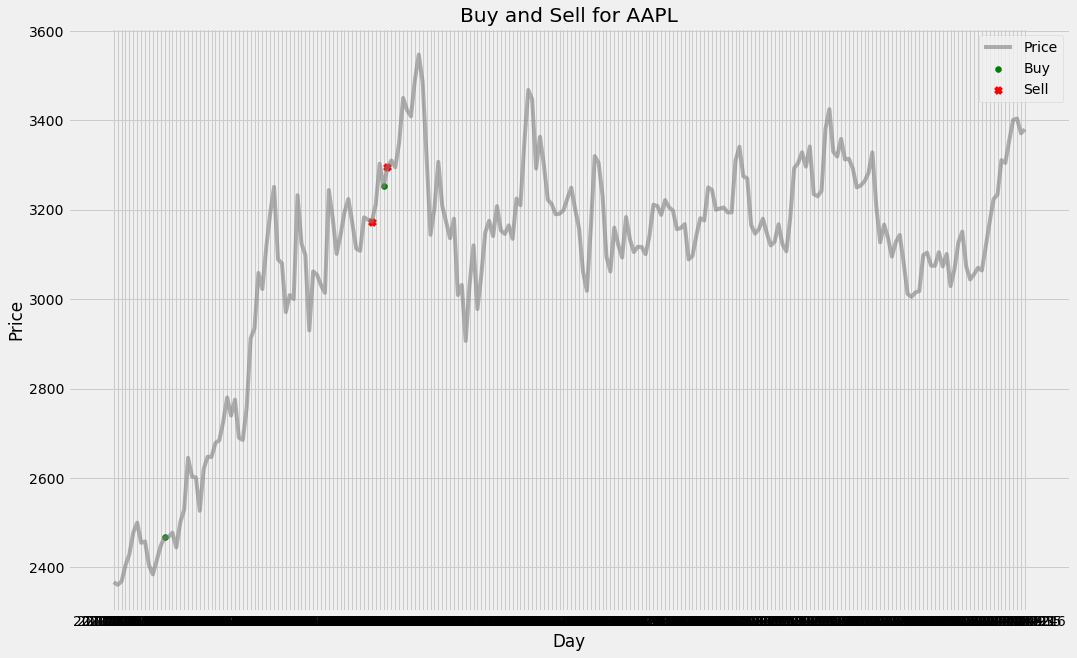

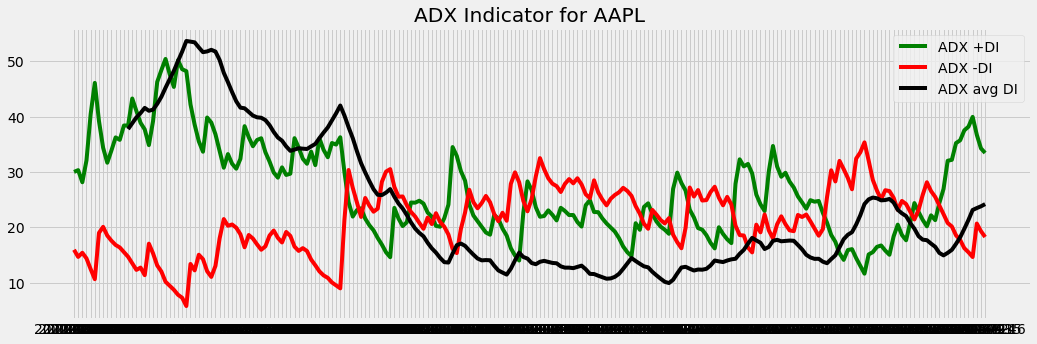

In [14]:
# Visualize SMAs and prices
plt.figure(figsize=(16,10))
plt.plot(df['Date'], df['Open'], label='Price', c='grey', alpha=0.6)
plt.scatter(buy_info[0], buy_info[1], marker='o', label='Buy', c='green')
plt.scatter(sell_info[0], sell_info[1], marker='x', label='Sell', c='red')

#plt.plot(data[['Date']], SMA20s[start_from:end_from], label='SMA20', c='green', alpha=0.6)
#plt.plot(data[['Date']], SMA50s[start_from:end_from], label='SMA50', c='red', alpha=0.6)

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Buy and Sell for AAPL')
plt.legend()
plt.show()

plt.figure(figsize=(16,5))
plt.title('ADX Indicator for AAPL')
plt.plot(df['Date'][14:], pos_directional_index, color='green', label='ADX +DI')
plt.plot(df['Date'][14:], neg_directional_index, color='red', label='ADX -DI')
plt.plot(df['Date'][27:], avg_direction_index, color='black', label='ADX avg DI')
plt.legend()
plt.show()